In [73]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
np.random.seed(0)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


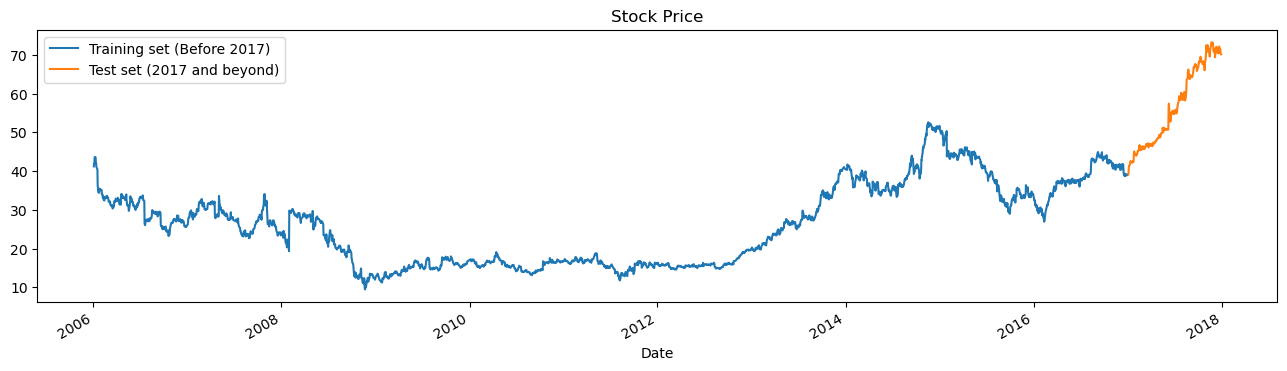

In [74]:
dataset = pd.read_csv('stock_price.csv', index_col='Date', parse_dates=['Date'])
display(dataset.head())

# We are going to predict the high attribute of stocks. Let's visualize it
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Stock Price')
plt.show()

In [75]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [76]:
rowswithnull =dataset[dataset.isnull().any(axis=1)]
rowswithnull.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,


In [77]:
rowswithoutnulls = dataset[dataset.notnull().all(axis=1)]
rowswithoutnulls.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [78]:
dataset = rowswithoutnulls
rowswithoutnulls.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [79]:
train_set = dataset[:'2016']["High"].values
test_set = dataset['2017':]["High"].values
print(train_set.shape, test_set.shape)

(2768,) (251,)


In [80]:
# Scaling the train and test sets
scaler = MinMaxScaler(feature_range=(0, 1))
train_set = scaler.fit_transform(np.reshape(train_set, (-1, 1)))
test_set = scaler.fit_transform(np.reshape(test_set, (-1, 1)))

sequence_length = 70
# Since RNNs work across time, we create a data structure with 'sequence_length' timesteps and 1 output
# So for each element of train set, we have 'sequence_length' previous training set elements 
X_train, Y_train = list(), list()
for i in range(train_set.shape[0] - sequence_length):
    X_train.append(train_set[i:i + sequence_length, 0])
    Y_train.append(train_set[i + sequence_length, 0])
X_train, Y_train = np.asarray(X_train), np.asarray(Y_train)

# Preparing the test set as well
X_test, Y_test = list(), list()
for i in range(test_set.shape[0] - sequence_length):
    X_test.append(test_set[i:i + sequence_length, 0])
    Y_test.append(test_set[i + sequence_length, 0])
X_test, Y_test = np.asarray(X_test), np.asarray(Y_test)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(2698, 70) (181, 70)
(2698,) (181,)


In [81]:
model = Sequential([
        LSTM(60, input_shape = (sequence_length,1), activation = 'tanh'),
        Dense(units = 64, activation="relu"),
        Dropout(0.1),
        Dense(units = 1, activation = 'relu'),
    ]) 

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60)                14880     
                                                                 
 dense_8 (Dense)             (None, 64)                3904      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18849 (73.63 KB)
Trainable params: 18849 (73.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [82]:
history = model.fit(X_train, Y_train,validation_data=(X_test,Y_test), epochs= 20, batch_size = 4)
loss_history = history.history['loss']

Epoch 1/20
675/675 [==============================] - 16s 18ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 2/20
675/675 [==============================] - 12s 17ms/step - loss: 0.0015 - val_loss: 0.0066
Epoch 3/20
675/675 [==============================] - 12s 17ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/20
675/675 [==============================] - 11s 16ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/20
675/675 [==============================] - 11s 17ms/step - loss: 9.5464e-04 - val_loss: 0.0012
Epoch 6/20
675/675 [==============================] - 11s 17ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 7/20
675/675 [==============================] - 11s 17ms/step - loss: 8.2789e-04 - val_loss: 0.0014
Epoch 8/20
675/675 [==============================] - 11s 17ms/step - loss: 8.0550e-04 - val_loss: 6.9450e-04
Epoch 9/20
675/675 [==============================] - 12s 17ms/step - loss: 7.5418e-04 - val_loss: 7.6003e-04
Epoch 10/20
675/675 [==============================] - 12s

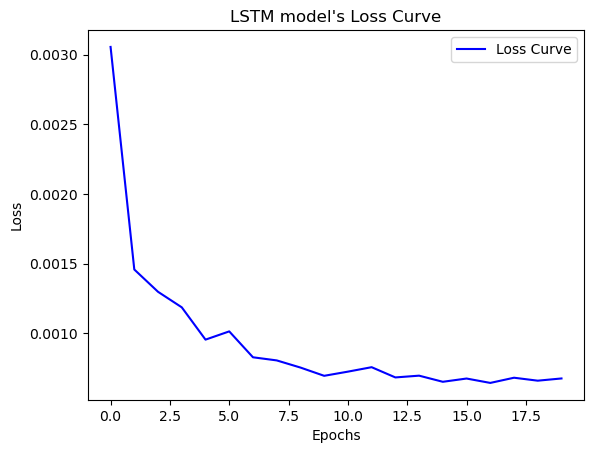

In [83]:
plt.plot(loss_history, color = 'blue', label = 'Loss Curve')
plt.title('LSTM model\'s Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 [==============================] - 1s 10ms/step


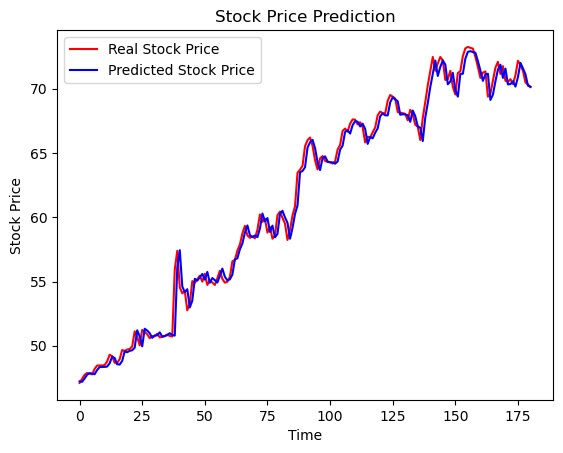

In [84]:
test_predict = model.predict(X_test)
orgpredict = scaler.inverse_transform(test_predict)
y_test_org =scaler.inverse_transform(Y_test.reshape(-1, 1))
plt.plot(y_test_org, color='red',label='Real Stock Price')
plt.plot(orgpredict, color='blue',label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

6/6 [==============================] - 0s 8ms/step


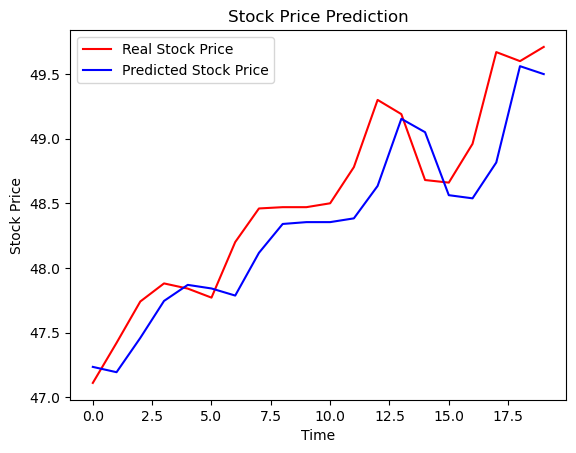

In [85]:
test_predict = model.predict(X_test)
orgpredict = scaler.inverse_transform(test_predict)
y_test_org =scaler.inverse_transform(Y_test.reshape(-1, 1))
plt.plot(y_test_org[:20], color='red',label='Real Stock Price')
plt.plot(orgpredict[:20], color='blue',label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [86]:
loss = (np.sum(np.square(Y_test - np.squeeze(test_predict)))/len(test_predict))
print("Loss: ",loss)

Loss:  0.0005903490919435857


In [87]:
r_squared = r2_score(Y_test[:20], np.squeeze(test_predict[:20]))
print("R-squared:", r_squared)

R-squared: 0.7916201866025804


In [88]:
y_pred = orgpredict[:20]
y_true = y_test_org[:20]
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

mae = mean_absolute_error(y_true, y_pred)
mdape = median_absolute_percentage_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Median Absolute Percentage Error (MdAPE):", mdape)
print("Root mean square error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.25541054534912105
Median Absolute Percentage Error (MdAPE): 0.36178998843486615
Root mean square error (RMSE): 0.332657285281629
